In [62]:
!pip install tensorflow
!pip install opencv-contrib-python
!pip install matplotlib

In [63]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow_datasets as tfds
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [16]:
# Carregar e preparar o dataset Cats vs Dogs
data, info = tfds.load("cats_vs_dogs", with_info=True, as_supervised=True)
train_data, test_data = data["train"].take(20000), data["train"].skip(20000)

# Preprocessamento de imagens
def preprocess(image, label):
    image = tf.image.resize(image, (160, 160))
    image = image / 255.0  # Normalização para [0, 1]
    return image, label

train_data = train_data.map(preprocess).shuffle(1000).batch(32)
test_data = test_data.map(preprocess).batch(32)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.GUQBV4_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [17]:
# Carregar o modelo base do MobileNetV2
base_model = MobileNetV2(input_shape=(160, 160, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Congelar as camadas pré-treinadas

# Construir o modelo com Transfer Learning
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # Saída binária para classificador
])

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [18]:
# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Treinamento
history = model.fit(train_data, epochs=5, validation_data=test_data)

# Avaliar o modelo
loss, accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 442s 696ms/step - accuracy: 0.8189 - loss: 0.4077 - val_accuracy: 0.9601 - val_loss: 0.1313
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 451s 710ms/step - accuracy: 0.9662 - loss: 0.1145 - val_accuracy: 0.9666 - val_loss: 0.0948
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 426s 679ms/step - accuracy: 0.9721 - loss: 0.0846 - val_accuracy: 0.9703 - val_loss: 0.0814
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 428s 683ms/step - accuracy: 0.9755 - loss: 0.0730 - val_accuracy: 0.9730 - val_loss: 0.0742
Epoch 5/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 445s 688ms/step - accuracy: 0.9770 - loss: 0.0670 - val_accuracy: 0.9752 - val_loss: 0.0700
102/102 ━━━━━━━━━━━━━━━━━━━━ 77s 552ms/step - accuracy: 0.9721 - loss: 0.0716
Test Accuracy: 97.52%


In [42]:
# Salvar o modelo treinado
model.save("cats_vs_dogs_classifier.keras")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


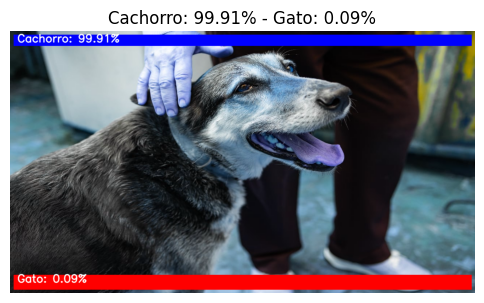

In [75]:
# Defina o caminho da sua imagem
image_path = "/content/Imagens/image2.jpg"

# Função para carregar e prever uma imagem
def predict_image(image_path):
    # Carregar e preprocessar a imagem
    image = tf.keras.preprocessing.image.load_img(image_path, target_size=(160, 160))
    image_array = tf.keras.preprocessing.image.img_to_array(image) / 255.0  # Normalizar para [0, 1]
    image_array = np.expand_dims(image_array, axis=0)  # Adicionar dimensão para lote

    # Fazer previsão (verifique se o modelo já foi carregado corretamente)
    prediction = model.predict(image_array)[0][0]  # Obter previsão
    dog_confidence = prediction  # Confiança de ser cachorro
    cat_confidence = 1 - prediction  # Confiança de ser gato

    # Carregar a imagem original novamente
    result_image = tf.keras.preprocessing.image.img_to_array(
        tf.keras.preprocessing.image.load_img(image_path, target_size=(720, 1280))
    ).astype(np.uint8)

    # Converter a imagem para RGB se necessário
    if result_image.shape[-1] == 1:
        result_image = cv2.cvtColor(result_image, cv2.COLOR_GRAY2BGR)

    # Criar as caixas delimitadoras para cachorro e gato
    height, width, _ = result_image.shape
    box_height = 40  # Altura da caixa
    padding = 10  # Espaçamento para o texto dentro da caixa

    # Caixa para cachorro
    dog_box = (10, 10, width - 10, box_height)
    # Caixa para gato
    cat_box = (10, height - box_height - 10, width - 10, height - 10)

    # Adicionar as caixas com a cor apropriada
    cv2.rectangle(result_image, (dog_box[0], dog_box[1]), (dog_box[2], dog_box[3]), (255, 0, 0), -1)  # Azul para cachorro
    cv2.rectangle(result_image, (cat_box[0], cat_box[1]), (cat_box[2], cat_box[3]), (0, 0, 255), -1)  # Vermelho para gato

    # Adicionar o texto nas caixas (porcentagem)
    dog_text = f"Cachorro: {dog_confidence * 100:.2f}%"
    cat_text = f"Gato: {cat_confidence * 100:.2f}%"

    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(result_image, dog_text, (dog_box[0] + padding, dog_box[1] + box_height // 2), font, 1, (255, 255, 255), 2, cv2.LINE_AA)
    cv2.putText(result_image, cat_text, (cat_box[0] + padding, cat_box[1] + box_height // 2), font, 1, (255, 255, 255), 2, cv2.LINE_AA)

    # Converter a imagem de BGR para RGB para exibição com o Matplotlib
    combined_rgb = cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB)

    # Exibir imagem com matplotlib
    plt.figure(figsize=(6, 6))
    plt.imshow(combined_rgb)
    plt.axis('off')
    plt.title(f"Cachorro: {dog_confidence * 100:.2f}% - Gato: {cat_confidence * 100:.2f}%")
    plt.show()

# Garantir que o matplotlib renderize as imagens no notebook do Colab
%matplotlib inline

# Chamar a função para prever a imagem
predict_image(image_path)